In [1]:
import os
os.chdir("..")
#!pip install -r requirements.txt

### Библиотеки

In [15]:
import boto3
# from dotenv import dotenv_values
import pandas as pd
from io import StringIO
import numpy as np
from tqdm.notebook import tqdm


import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
sns.set_style("darkgrid")

from scipy.optimize import minimize, Bounds, NonlinearConstraint
from portfolio_analytics.covariances import rolling_covariance_with_step, expanding_covariance_with_step

from portfolio_analytics.optimizer import Optimizer, OptimizerIS
from portfolio_analytics.utils import plot_efficient_frontier_curve

import warnings
warnings.filterwarnings('ignore')

# config = dotenv_values(".env")

### Данные с S3

In [7]:
session = boto3.session.Session()
s3 = session.client(
    service_name='s3',
    # endpoint_url='https://storage.yandexcloud.net',
    # aws_access_key_id = config['s3_aws_access_key_id'],
    # aws_secret_access_key = config['s3_aws_secret_access_key']
)

In [8]:
bytes_data = s3.get_object(Bucket='portfoliodata', Key="prepared_data/returns_clipped.csv")['Body'].read()
csv_data = StringIO(str(bytes_data,'utf-8')) 

data = pd.read_csv(csv_data)
date_data = pd.to_datetime(data['begin'])
#date_data = data.iloc[:,1]
return_data = data.drop(columns=["begin"], axis=1)
return_data_nc = return_data.copy()
return_data

,SBER,LKOH,GAZP,AFLT,ROSN,NVTK,MGNT,PLZL,SNGS,CHMF,...,APTK,IRKT,VTBR,GMKN,TGKB,TGKA,SVAV,AFKS,NMTP,MSRS
0,0.016495,-0.008177,-0.000822,0.013493,0.012558,0.005102,-0.000824,0.037725,-0.002328,0.007866,...,0.008994,0.017621,0.000822,0.014640,0.008368,0.000000,0.022682,0.019013,-0.008217,0.003984
1,0.011301,-0.012609,0.009960,0.003879,-0.031174,0.036050,0.035728,0.000829,-0.000986,0.017187,...,-0.013928,-0.003896,0.000000,-0.008259,-0.012448,-0.006270,0.024286,0.040105,-0.007660,0.031940
2,0.002865,-0.015717,0.021888,0.012845,0.002776,0.029029,0.007430,0.037725,0.009605,0.023276,...,-0.008475,-0.000565,-0.006568,0.019318,0.016807,-0.006309,-0.023703,-0.031385,-0.015438,0.013363
3,0.006762,-0.006502,-0.009513,0.013507,-0.009018,-0.009388,-0.013778,0.018963,-0.009514,0.019377,...,0.000000,-0.003348,-0.015702,-0.018071,-0.008264,-0.003175,0.006421,-0.003352,-0.016000,0.021245
4,-0.036988,-0.029475,-0.030595,-0.017803,-0.031174,-0.033116,-0.021324,-0.031904,-0.033274,-0.035623,...,-0.028490,-0.018325,-0.034678,-0.033659,-0.029167,-0.012739,-0.020575,-0.035874,-0.034296,-0.031759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4252,0.027805,0.022611,0.032824,0.023126,0.016152,0.015294,0.016581,0.018551,0.000635,0.022891,...,-0.013151,0.003984,0.035729,0.028963,-0.007317,0.009505,0.015291,0.029904,0.038936,-0.002248
4253,-0.007840,0.002218,-0.009523,0.003281,-0.004897,0.021950,0.029140,0.001968,0.014585,0.010845,...,-0.005923,-0.005952,-0.010323,0.015370,-0.008190,0.002853,-0.003012,-0.004804,-0.013722,0.012618
4254,0.006084,-0.001785,0.007093,0.011083,0.020549,-0.000632,0.006958,0.009856,-0.005417,0.010048,...,-0.006330,0.009980,0.009902,0.012584,-0.008258,0.030441,0.003776,0.013559,0.026667,0.012461
4255,0.006010,0.001073,0.014164,0.035993,0.008460,0.002739,-0.031448,-0.015065,0.010264,0.038779,...,-0.002248,0.029644,0.020918,0.024856,-0.010824,0.026229,0.014296,0.032217,0.009599,0.010989


In [9]:
# выбросы
# lower_bound = return_data.quantile(0.05)
# upper_bound = return_data.quantile(0.95)
# return_data = return_data.clip(lower=lower_bound, upper=upper_bound, axis=1)
# return_data['begin'] = date_data


# csv_data = return_data.to_csv(index=False).encode('utf-8')
# s3.put_object(
#     Bucket='portfoliodata',
#     Key=f'prepared_data/returns_clipped.csv',
#     Body=csv_data
# )

In [10]:
bytes_data = s3.get_object(Bucket='portfoliodata', Key="stock_meta_data.csv")['Body'].read()
csv_data = StringIO(str(bytes_data,'utf-8')) 
meta_data=pd.read_csv(csv_data).iloc[:,1:]
meta_data

,id,secid,shortname,regnumber,name,isin,is_traded,emitent_id,emitent_title,emitent_inn,emitent_okpo,gosreg,type,group,primary_boardid,marketprice_boardid
0,424433251,ABIO,iАРТГЕН ао,1-01-08902-A,"ПАО ""Артген""",RU000A0JNAB6,1,1142.0,"Публичное акционерное общество ""Артген биотех""",7.702509e+09,71328785.0,1-01-08902-A,common_share,stock_shares,TQBR,TQBR
1,12441,ABRD,АбрауДюрсо,1-02-12500-A,Абрау-Дюрсо ПАО ао,RU000A0JS5T7,1,4787.0,"Публичное акционерное общество ""Абрау – Дюрсо""",7.727621e+09,81521198.0,1-02-12500-A,common_share,stock_shares,TQBR,TQBR
2,2699,AFKS,Система ао,1-05-01669-A,"АФК ""Система"" ПАО ао",RU000A0DQZE3,1,777.0,"Публичное акционерное общество ""Акционерная фи...",7.703105e+09,27987276.0,1-05-01669-A,common_share,stock_shares,TQBR,TQBR
3,2700,AFLT,Аэрофлот,1-01-00010-A,Аэрофлот-росс.авиалин(ПАО)ао,RU0009062285,1,1242.0,"Публичное акционерное общество ""Аэрофлот – рос...",7.712040e+09,29063984.0,1-01-00010-A,common_share,stock_shares,TQBR,TQBR
4,76079,AGRO,AGRO-гдр,NaN,ГДР ROS AGRO PLC ORD SHS,US7496552057,1,7502.0,ROS AGRO PLC,1.003487e+07,NaN,NaN,depositary_receipt,stock_dr,TQBR,TQBR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412,8151,ziop,"АО ""ЗиО-Подольск""",1-01-04090-A,"Акционерное общество ""Машиностроительный завод...",RU000A0JQ6B5,0,3685.0,"Акционерное общество ""Машиностроительный завод...",5.036041e+09,NaN,1-01-04090-A,common_share,stock_shares,EQNE,NaN
2413,7778,ZIRE,ЗИРЕРА ао,1-01-57303-D,"""ЗИРЕРА"" ОАО - ао",RU000A0JRFT8,0,4518.0,"Открытое акционерное общество ""ЗИРЕРА""",1.655203e+09,68734469.0,1-01-57303-D,common_share,stock_shares,TQNE,NaN
2414,3898,ZMZN,ЗМЗ-ао,1-01-00230-A,Заволжский мотор.з-д ПАО ао,RU0009101539,0,1004.0,"Публичное акционерное общество ""Заволжский мот...",5.248004e+09,NaN,1-01-00230-A,common_share,stock_shares,TQBR,TQBR
2415,3899,ZMZNP,ЗМЗ-ап,2-01-00230-A,Заволжский мотор.завод ПАО ап,RU0006752854,0,1004.0,"Публичное акционерное общество ""Заволжский мот...",5.248004e+09,NaN,2-01-00230-A,preferred_share,stock_shares,TQBR,TQBR


### Анализ влияния ограничений в optimizer на границу эффективных портфелей

#### Задание 4

In [11]:
data_2018_year = return_data.iloc[date_data[date_data.dt.year == 2018].index]

#### Задание 5

In [13]:
# на 2018 году

  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 800x800 with 0 Axes>

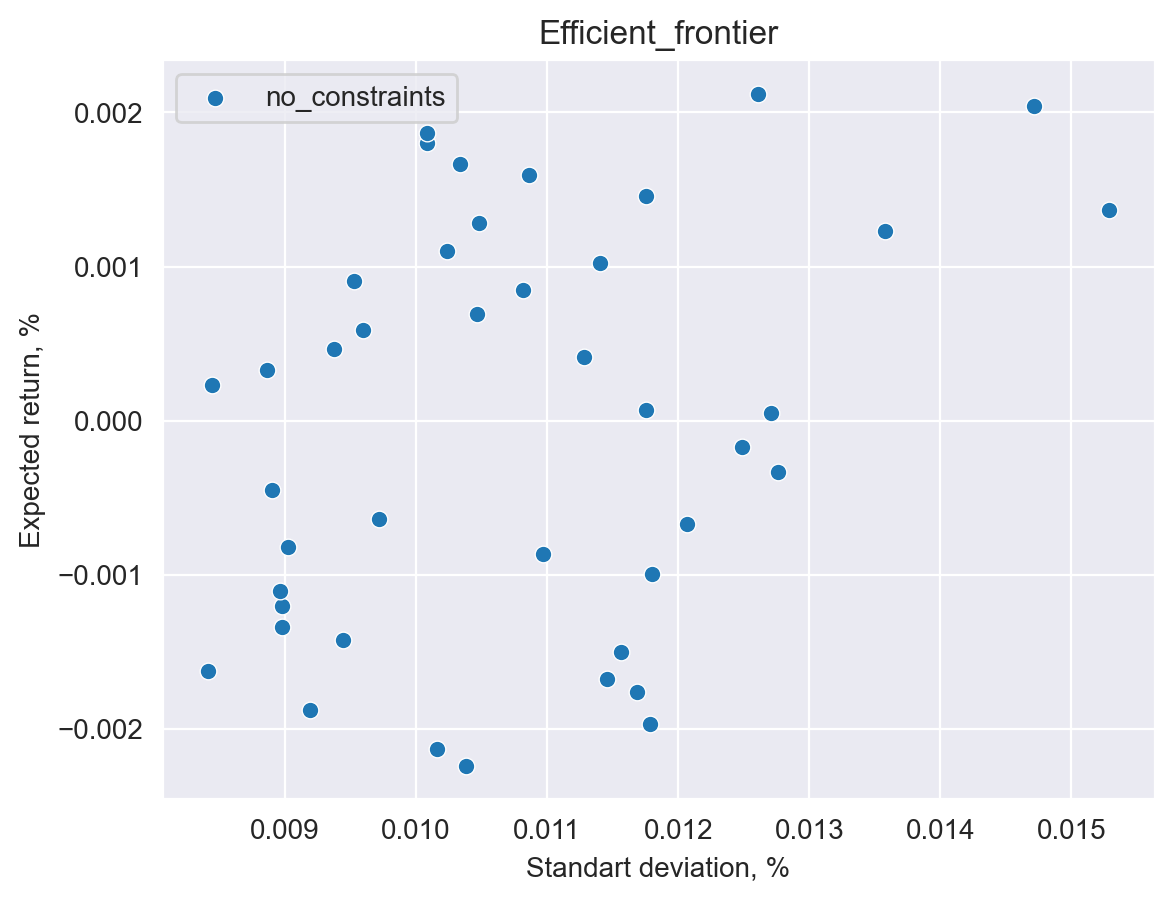

In [14]:
optim = Optimizer(data_2018_year)
res_5 = optim.efficient_frontier_curve()

plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
plot_efficient_frontier_curve([x[1] for x in res_5], [x[0] for x in res_5], label='no_constraints', ax=ax)

## Задание 25

  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 800x800 with 0 Axes>

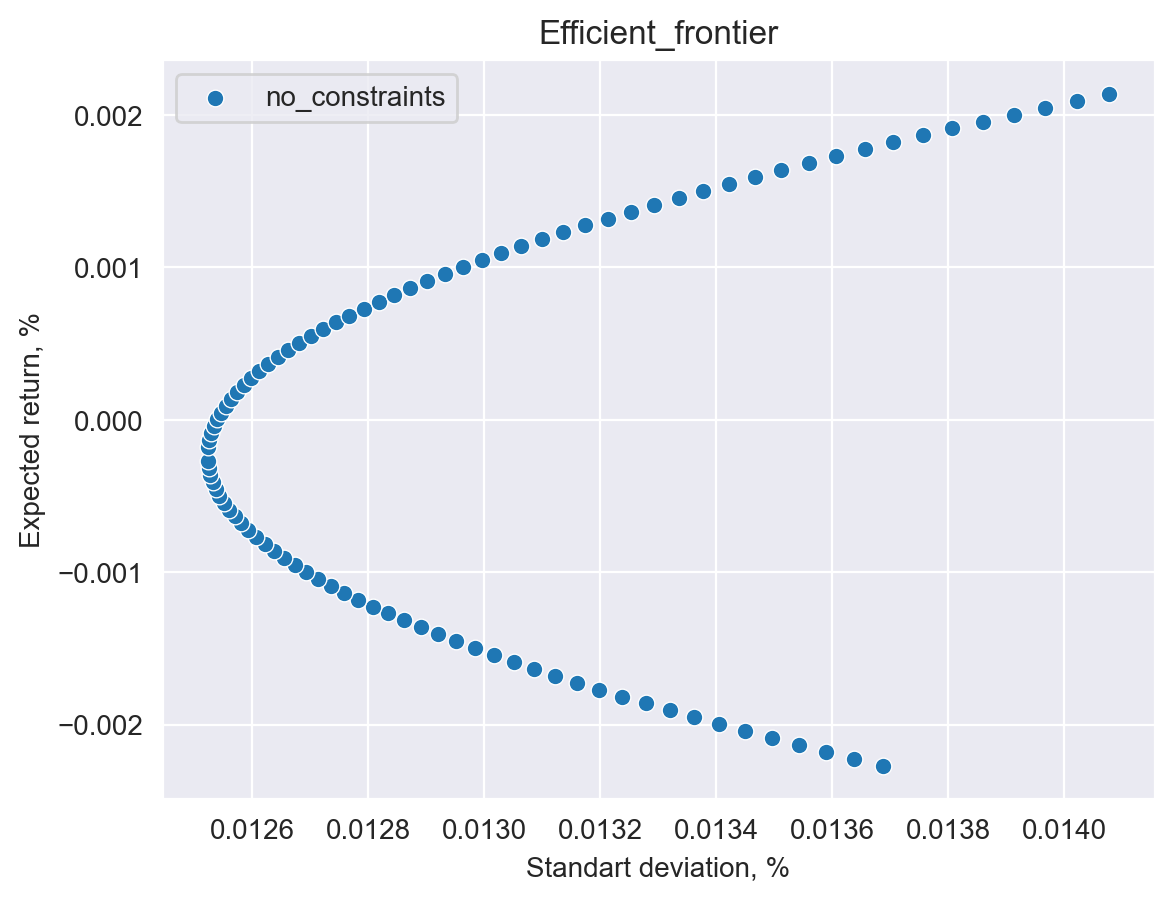

In [17]:
optim = OptimizerIS(data_2018_year)
res_5 = optim.efficient_frontier_curve_with_is()

plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
plot_efficient_frontier_curve([x[1] for x in res_5], [x[0] for x in res_5], label='no_constraints', ax=ax)

In [ ]:
r_f = 0.06/252  

best_sharpe = -np.inf
best_point = None  
for (ret, std, w) in res_5:
    sharpe = (ret - r_f) / std if std != 0 else -np.inf
    if sharpe > best_sharpe:
        best_sharpe = sharpe
        best_point = (ret, std, w)

if best_point is not None:
    print("Максимальный Sharpe Ratio:", best_sharpe)
    print("Доходность:", best_point[0])
    print("Риск (std):", best_point[1])
    print("Веса:", best_point[2])
else:
    print("Не удалось найти портфель на фронтире.")

Максимальный Sharpe Ratio: 0.13769708677315742
Доходность: 0.002184430187048773
Риск (std): 0.014134902884038009
Веса: [ 0.06466941 -0.15241265 -0.08999989 -0.13792223  0.28638723  0.30438286
  0.14054917 -0.1125967  -0.06044149 -0.08812711  0.28364097 -0.21609786
 -0.0961136   0.26168766  0.17585419  0.159567    0.15663998 -0.05608343
  0.17642491  0.0442168  -0.21571193  0.1798413   0.03578863  0.16069951
 -0.03288378 -0.23708095  0.05940059 -0.1041495  -0.06265158  0.17252249]


In [21]:
data_2019_year = return_data.iloc[date_data[date_data.dt.year == 2019].index]

  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 800x800 with 0 Axes>

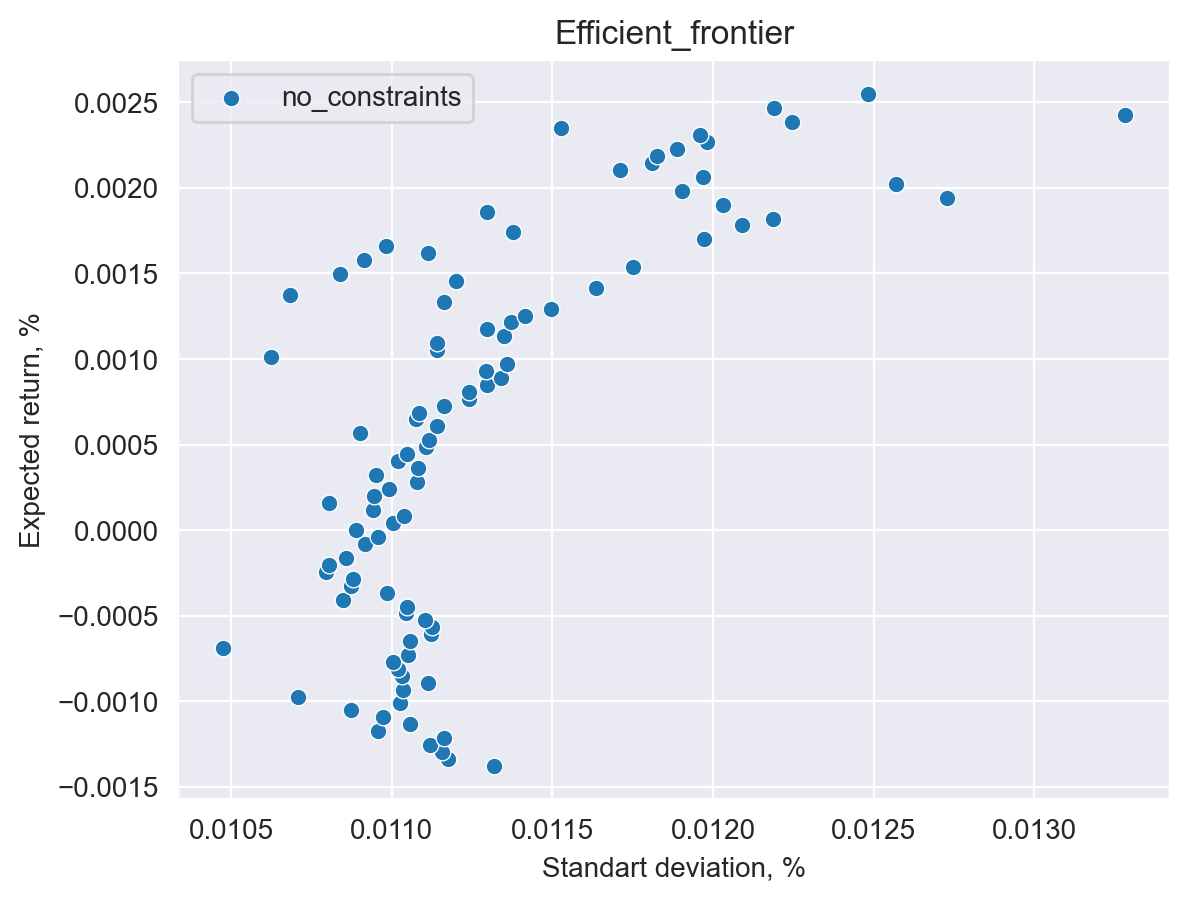

In [24]:
optim = OptimizerIS(
    data_2019_year,
    w_old=best_point[2],
    is_costs=np.ones(30) * 0.05
)
res = optim.efficient_frontier_curve_with_is()

plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
plot_efficient_frontier_curve([x[1] for x in res], [x[0] for x in res], label='no_constraints', ax=ax)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import os


def plot_efficient_frontier_curve(std_vals, ret_vals, label, ax, color='b'):
    """ Утилита: рисует (std, ret) одной линии на заданном ax. """
    ax.plot(std_vals, ret_vals, marker='o', label=label, color=color)
    ax.set_xlabel("Risk (std)")
    ax.set_ylabel("Expected Return")
    ax.legend(loc='best')
    ax.grid(True)


years = np.arange(2008, 2025, 1)  # пример


all_risks = []
all_returns = []

for yr in years:
    mask = date_data[date_data.dt.year == yr].index
    data_year = return_data.loc[mask]
    if data_year.empty:
        continue


    optim_temp = Optimizer(data_year)
    frontier_temp = optim_temp.efficient_frontier_curve(n_point=50)


    for (ret, std, _) in frontier_temp:
        all_risks.append(std)
        all_returns.append(ret)

risk_min, risk_max = min(all_risks), max(all_risks)
ret_min, ret_max = min(all_returns), max(all_returns)

risk_pad = 0.02 * (risk_max - risk_min)
ret_pad = 0.02 * (ret_max - ret_min)
fixed_xmin = risk_min - risk_pad
fixed_xmax = risk_max + risk_pad
fixed_ymin = ret_min - ret_pad
fixed_ymax = ret_max + ret_pad



frames = []  
w_old = None  
r_f = 0.1 / 252  

for i, yr in enumerate(years):
    mask = date_data[date_data.dt.year == yr].index
    data_year = return_data.loc[mask]

    if data_year.empty:
        print(f"Нет данных за {yr}")
        continue

    if i == 0:
        optim = OptimizerIS(data_year, w_old=None, is_costs=None, alpha=0.0)
    else:
        optim = OptimizerIS(data_year, w_old=w_old, is_costs=np.ones(30)*0.1, alpha=0.01)

    frontier = optim.efficient_frontier_curve_with_is(n_points=50)

    # Выбираем точку с макс. Sharpe
    best_sharpe = -np.inf
    best_point = None
    for (ret, std, w) in frontier:
        if std > 0:
            sharpe = (ret - r_f)/std
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_point = (ret, std, w)

    if best_point is not None:
        print(f"Год={yr} Макс. Sharpe={best_sharpe:.4f}, ret={best_point[0]:.4f}, std={best_point[1]:.4f}")
        # Обновляем w_old
        w_old = best_point[2]
    else:
        print(f"Год={yr}: Не удалось найти портфель (?)")

    fig, ax = plt.subplots(figsize=(8,8))

    ret_vals = [x[0] for x in frontier]
    std_vals = [x[1] for x in frontier]
    plot_efficient_frontier_curve(std_vals, ret_vals, label=f'{yr}', ax=ax)

    if best_point is not None:
        ax.scatter(best_point[1], best_point[0], c='r', s=80, marker='x', label='Max Sharpe')
        ax.legend()

    ax.set_xlim(fixed_xmin, fixed_xmax)
    ax.set_ylim(fixed_ymin, fixed_ymax)
    ax.set_title(f"Efficient Frontier with IS: year={yr}")

    fname = f"frontier_{yr}.png"
    plt.savefig(fname, dpi=100, bbox_inches='tight')
    plt.close(fig)

    frames.append(fname)

images = []
for fn in frames:
    img = imageio.v2.imread(fn)
    images.append(img)

imageio.mimsave('frontier_years.gif', images, fps=1)  

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Год=2008 Макс. Sharpe=-0.0270, ret=-0.0001, std=0.0199


  0%|          | 0/50 [00:00<?, ?it/s]

Год=2009 Макс. Sharpe=0.2423, ret=0.0062, std=0.0239


  0%|          | 0/50 [00:00<?, ?it/s]

Год=2010 Макс. Sharpe=0.1474, ret=0.0027, std=0.0155


  0%|          | 0/50 [00:00<?, ?it/s]

Год=2011 Макс. Sharpe=0.0586, ret=0.0014, std=0.0169


  0%|          | 0/50 [00:00<?, ?it/s]

Год=2012 Макс. Sharpe=0.1317, ret=0.0024, std=0.0152


  0%|          | 0/50 [00:00<?, ?it/s]

Год=2013 Макс. Sharpe=0.1353, ret=0.0023, std=0.0144


  0%|          | 0/50 [00:00<?, ?it/s]

Год=2014 Макс. Sharpe=0.1289, ret=0.0024, std=0.0156


  0%|          | 0/50 [00:00<?, ?it/s]

Год=2015 Макс. Sharpe=0.1796, ret=0.0033, std=0.0162


  0%|          | 0/50 [00:00<?, ?it/s]

Год=2016 Макс. Sharpe=0.1817, ret=0.0036, std=0.0174


  0%|          | 0/50 [00:00<?, ?it/s]

Год=2017 Макс. Sharpe=0.0668, ret=0.0015, std=0.0161


  0%|          | 0/50 [00:00<?, ?it/s]

Год=2018 Макс. Sharpe=0.1083, ret=0.0021, std=0.0161


  0%|          | 0/50 [00:00<?, ?it/s]

Год=2019 Макс. Sharpe=0.1422, ret=0.0024, std=0.0140


  0%|          | 0/50 [00:00<?, ?it/s]

Год=2020 Макс. Sharpe=0.1270, ret=0.0028, std=0.0191


  0%|          | 0/50 [00:00<?, ?it/s]

Год=2021 Макс. Sharpe=0.1311, ret=0.0025, std=0.0164


  0%|          | 0/50 [00:00<?, ?it/s]

Год=2022 Макс. Sharpe=0.0289, ret=0.0010, std=0.0218


  0%|          | 0/50 [00:00<?, ?it/s]

Год=2023 Макс. Sharpe=0.1464, ret=0.0028, std=0.0162


  0%|          | 0/50 [00:00<?, ?it/s]

Год=2024 Макс. Sharpe=0.0720, ret=0.0016, std=0.0164
GIF сохранён: frontier_years.gif
